# Compute inference throughput for different scenarios

# Setup and imports

In [1]:
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torchvision
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.2.1+cu121
CUDA version: 12.1
cuDNN version: 8902
CUDA available: True


# Choose model here from torchvision

In [2]:
torch.cuda.is_available()

True

In [3]:
# get model with torchhub
torch.hub.list('pytorch/vision')

Using cache found in /home/tguy/.cache/torch/hub/pytorch_vision_main


['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fcn_resnet101',
 'fcn_resnet50',
 'get_model_weights',
 'get_weight',
 'googlenet',
 'inception_v3',
 'lraspp_mobilenet_v3_large',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'r2plus1d_18',
 'r3d_18',
 'raft_large',
 'raft_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1

In [4]:
model_name = "resnet34"
model = torch.hub.load('pytorch/vision', model_name)
model.eval()

Using cache found in /home/tguy/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
input_shape = (3, 224, 224)
input_sample = torch.randn(1, *input_shape)
model(torch.rand(1, 3, 224, 224)).shape

torch.Size([1, 1000])

# Influence of batch size on inference throughput

## CPU

In [6]:
device = "cpu"
model = model.to(device)

In [7]:
# dummy dataset
n_points = 100
input_shape = (3, 224, 224)
X = torch.rand(n_points, *input_shape)
dataset = TensorDataset(X)

In [31]:
n_loops = 10
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
time_to_process = {
    batch_size: [] for batch_size in batch_sizes
}

for _ in tqdm(range(n_loops)):
    random.shuffle(batch_sizes)
    for batch_size in batch_sizes:
        print(f"\nInference on dataset with model {model_name} and batch size {batch_size}")
        dl = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
        )
        start_time = time.perf_counter()
        for (x,) in dl:
            x = x.to(device)
            model(x)
        time_to_process[batch_size].append(time.perf_counter() - start_time)
        print(f"Time to process: {time_to_process[batch_size][-1]:.2f} s")
        print("-" * 50)



  0%|          | 0/10 [00:00<?, ?it/s]


Inference on dataset with model resnet34 and batch size 1
Time to process: 2.86 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 4
Time to process: 2.22 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 32
Time to process: 1.74 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 64
Time to process: 1.96 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 8
Time to process: 1.86 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 2
Time to process: 2.38 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 16
Time to process: 1.89 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 2


In [59]:
df_process_times_cpu = pd.DataFrame(
    {
        "batch_size": [batch_size for batch_size in time_to_process for _ in time_to_process[batch_size]],
        "time_to_process": [time for times in time_to_process.values() for time in times],
    }
)

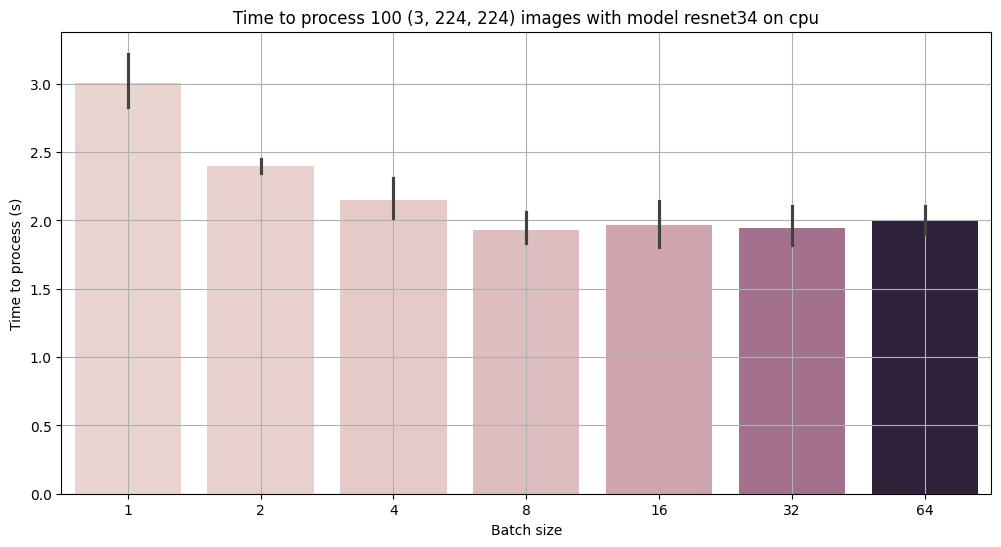

In [62]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_process_times_cpu, x="batch_size", y="time_to_process", hue="batch_size", legend=False)
ax.set_title(f"Time to process {n_points} {input_shape} images with model {model_name} on {device}")
ax.set(xlabel="Batch size", ylabel="Time to process (s)")
ax.grid(True)

Increasing batch size for cpu prediction speeds up inference. Gain is not linear and saturates at some point.
It remains limited (-33% for batch size 8 compared to 1)

## GPU

In [69]:
device = "cuda"
model = model.to(device)

# dummy dataset
n_points = 1000
input_shape = (3, 224, 224)
X = torch.rand(n_points, *input_shape)
dataset = TensorDataset(X)

In [70]:
n_loops = 10
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
time_to_process = {
    batch_size: [] for batch_size in batch_sizes
}

for _ in tqdm(range(n_loops)):
    random.shuffle(batch_sizes)
    for batch_size in batch_sizes:
        print(f"\nInference on dataset with model {model_name} and batch size {batch_size}")
        dl = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
        )
        start_time = time.perf_counter()
        for (x,) in dl:
            x = x.to(device)
            model(x)
        time_to_process[batch_size].append(time.perf_counter() - start_time)
        print(f"Time to process: {time_to_process[batch_size][-1]:.2f} s")
        print("-" * 50)


  0%|          | 0/10 [00:00<?, ?it/s]


Inference on dataset with model resnet34 and batch size 1
Time to process: 3.97 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 4
Time to process: 1.09 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 32
Time to process: 0.55 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 64
Time to process: 0.48 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 8
Time to process: 0.63 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 16
Time to process: 0.53 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 2
Time to process: 1.96 s
--------------------------------------------------

Inference on dataset with model resnet34 and batch size 2


In [85]:
df_process_times_gpu = pd.DataFrame(
    {
        "batch_size": [batch_size for batch_size in time_to_process for _ in time_to_process[batch_size]],
        "time_to_process": [time for times in time_to_process.values() for time in times],
    }
)
df_process_times_gpu["inference_throughput"] = n_points / df_process_times_gpu.time_to_process
gpu_process_time_speedup = (
    df_process_times_gpu[df_process_times_gpu["batch_size"] == 1].time_to_process.mean()
    / df_process_times_gpu.groupby("batch_size").time_to_process.mean()
)

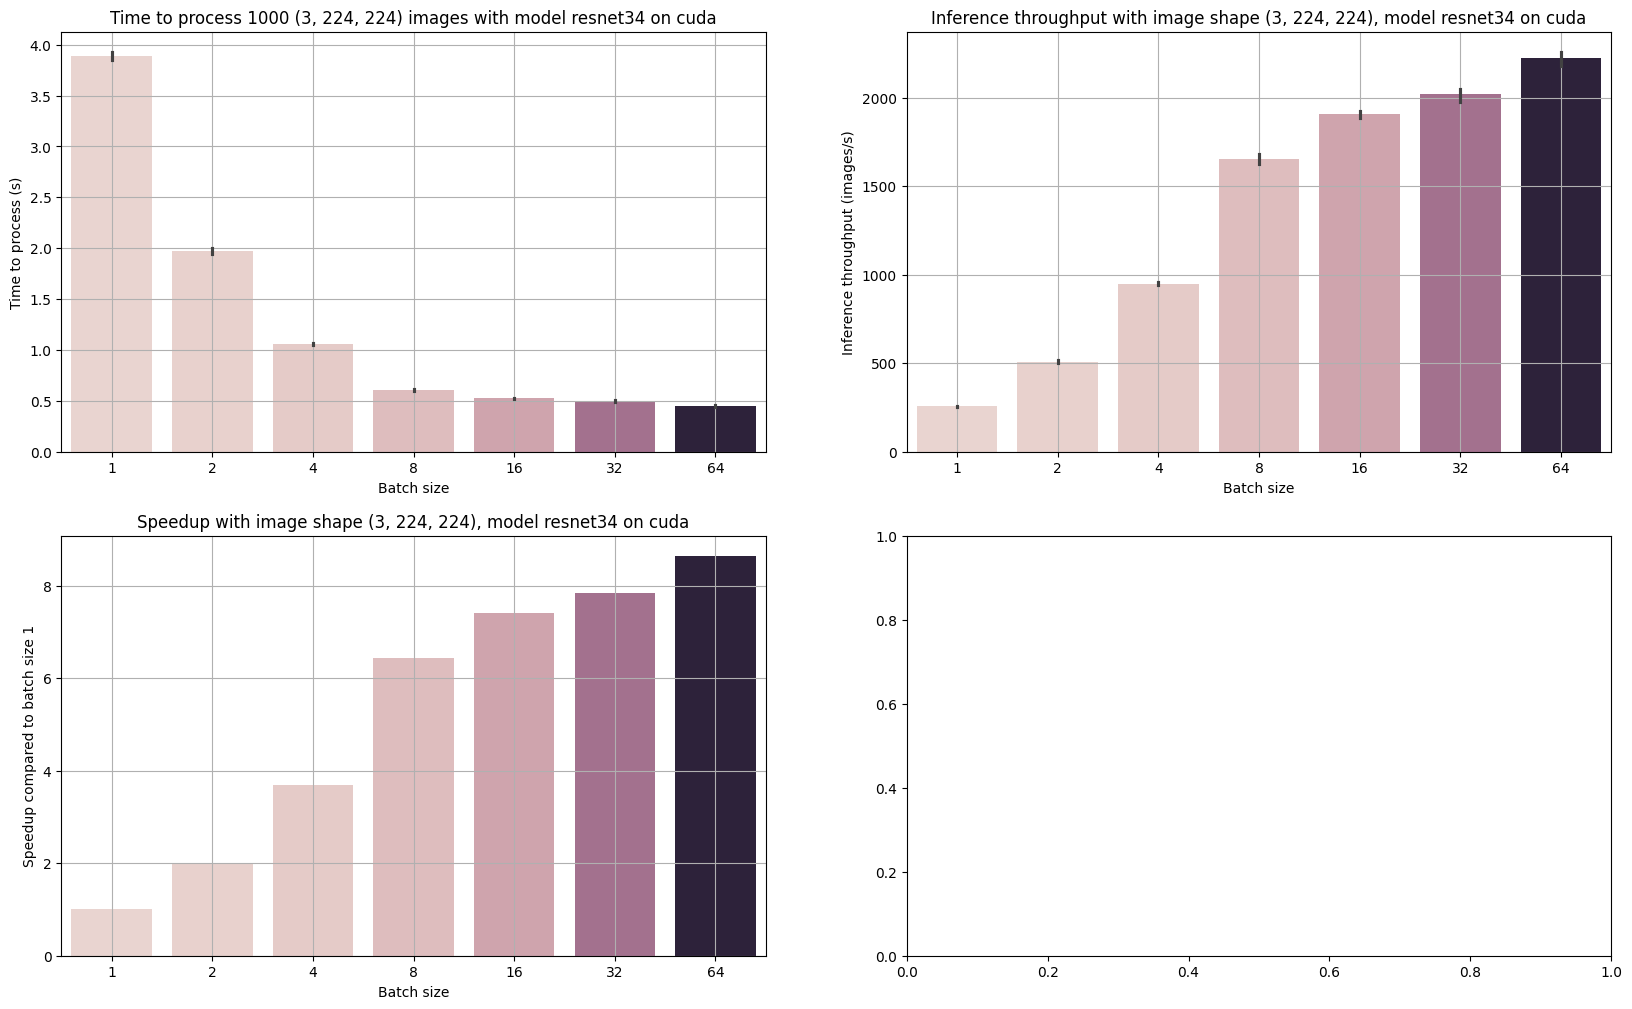

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# total time to process
sns.barplot(data=df_process_times_gpu, x="batch_size", y="time_to_process", hue="batch_size", legend=False, ax=axes[0, 0])
axes[0, 0].set_title(f"Time to process {n_points} {input_shape} images with model {model_name} on {device}")
axes[0, 0].set(xlabel="Batch size", ylabel="Time to process (s)")
axes[0, 0].grid(True)

sns.barplot(data=df_process_times_gpu, x="batch_size", y="inference_throughput", hue="batch_size", legend=False, ax=axes[0, 1])
axes[0, 1].set_title(f"Inference throughput with image shape {input_shape}, model {model_name} on {device}")
axes[0, 1].set(xlabel="Batch size", ylabel="Inference throughput (images/s)")
axes[0, 1].grid(True)


sns.barplot(x=gpu_process_time_speedup.index.values, y=gpu_process_time_speedup, hue=gpu_process_time_speedup.index.values, legend=False, ax=axes[1, 0])
axes[1, 0].set_title(f"Speedup with image shape {input_shape}, model {model_name} on {device}")
axes[1, 0].set(xlabel="Batch size", ylabel="Speedup compared to batch size 1")
axes[1, 0].grid(True)


Compared to the cpu case, we can observe huge throughput gains with higher batch sizes.
We have up to 8 times higher throughput with batch size 32 compared to batch size 1.
As with the cpu, it tends to saturate at some point.